<font size=20>**Using SHAP Values for Model Interpretability**<font>

In [12]:
#!pip install shap
#!pip install shap
#! pip install dice-ml


# Imports

In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split



import pickle
import shap
shap.initjs()


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Loading Data

In [3]:
df = pd.read_csv('../processed_data/cleaned_data_final.csv')
df.head(5)


,name,male,origin,isMarried,isNoble,popularity,isAlive,season,episode,deaths,episode_num
0,Viserys II Targaryen,1,House Targaryen,0,0,0.605351,0,8,The Bells,Lord Varys - Burned alive by Drogon with his f...,71
1,Walder Frey,1,House Frey,1,1,0.896321,0,6,The Winds of Winter,Lord Walder Frey - Throat slit by Arya Stark w...,60
2,Addison Hill,1,House Lannister,0,1,0.267559,1,0,NaN,NaN,0
3,Aemma Arryn,0,House Arryn,1,1,0.183946,0,5,The Gift,Maester Aemon Targaryen - Died of natural causes.,47
4,Sylva Santagar,0,House Martell,1,1,0.043478,1,0,NaN,NaN,0


## Setting X and y

In [8]:
X = df
X = X.drop(columns = ["name",'isAlive','episode','deaths','season',
       'episode_num'], axis=1)

y = df[["isAlive"]]

print(f'Features: {X.columns},\n \ny.head(5):\n{y.head()}')


Features: Index(['male', 'origin', 'isMarried', 'isNoble', 'popularity'], dtype='object'),
 
y.head(5):
   isAlive
0        0
1        0
2        1
3        0
4        1


In [10]:
model_xgb = pickle.load(open( "../got_survival/models_pickle/death_model.pkl", "rb"))


In [11]:
model_xgb


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  Pipeline(steps=[('standar_scaler',
                                                                   StandardScaler())]),
                                                  ['popularity']),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['origin']),
                                                 ('passthrough', 'passthrough',
                                                  ['isMarried', 'isNoble',
                                                   'male'])])),
                ('xgbclassifier',
                 XGBClassifier(base_sc...
                               feature_types=None, gamma=0.558,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.024, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=6, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [24]:
model_xgb.__dict__


{'steps': [('columntransformer',
   ColumnTransformer(transformers=[('num_transformer',
                                    Pipeline(steps=[('standar_scaler',
                                                     StandardScaler())]),
                                    ['popularity']),
                                   ('cat_transformer',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    ['origin']),
                                   ('passthrough', 'passthrough',
                                    ['isMarried', 'isNoble', 'male'])])),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric='logloss',
                 feature_typ

In [67]:
X_processed = model_xgb["columntransformer"].transform(X)


In [199]:
model_xgb["xgbclassifier"].predict(X_processed)


array([0, 0, 0, ..., 1, 1, 0])

In [200]:
shap.initjs()

# Calculate SHAP values
X100 = shap.utils.sample(X_processed, 200)
explainer = shap.TreeExplainer(model_xgb["xgbclassifier"],X100)
shap_values = explainer(X_processed)


[18:09:04] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


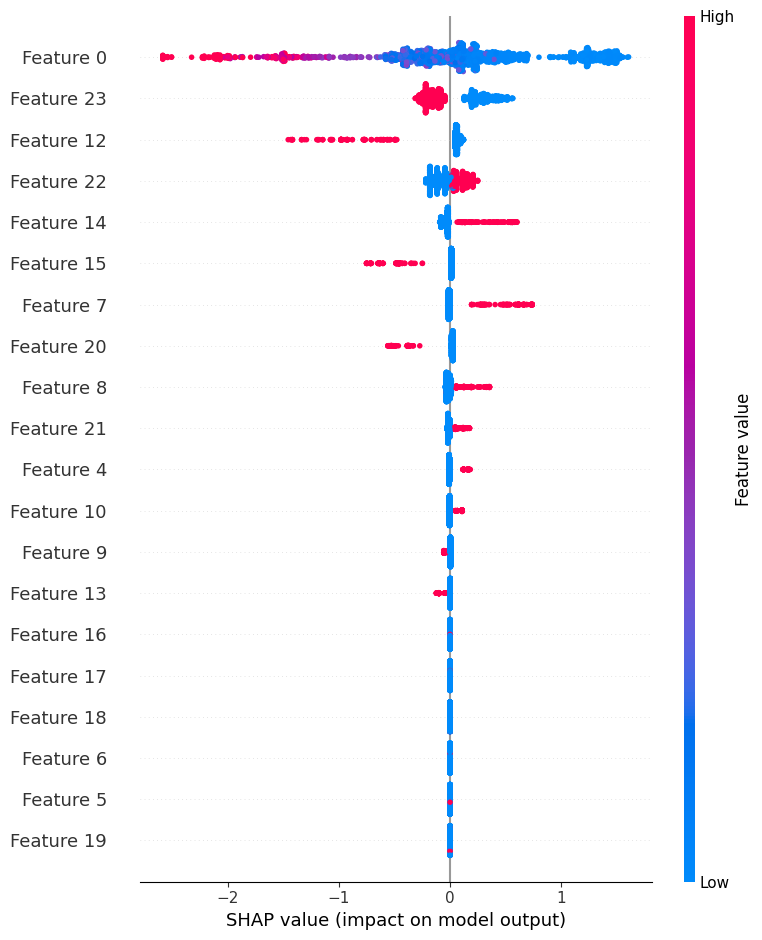

In [201]:
shap.summary_plot(shap_values, X_processed)


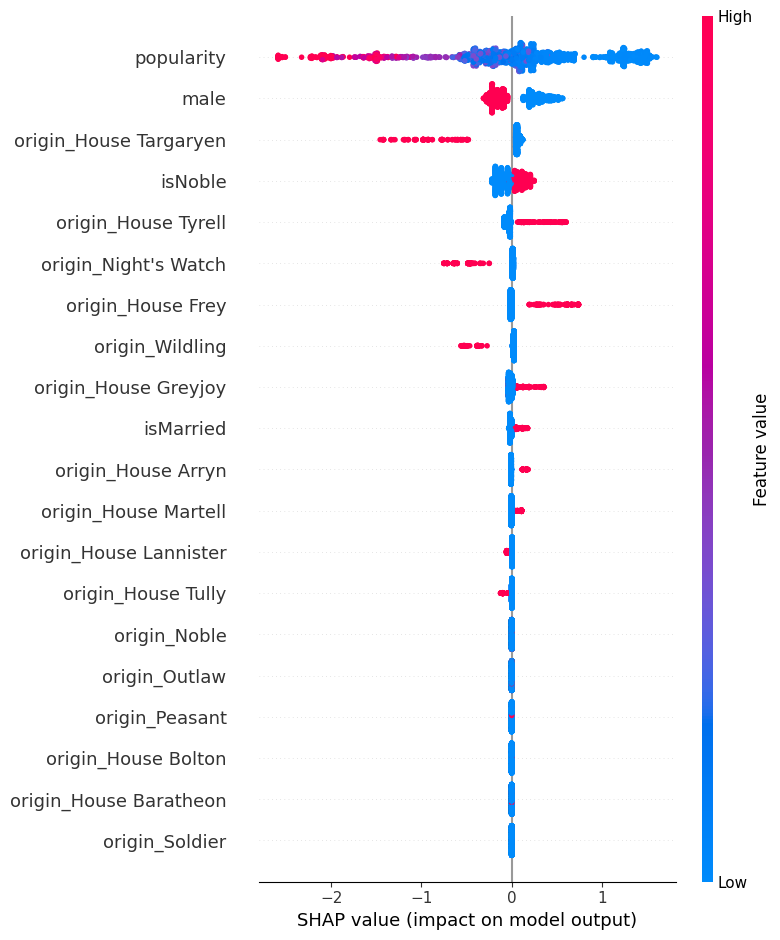

In [202]:
test = pd.DataFrame(X_processed)
test.columns = [x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]
shap.summary_plot(shap_values, test)


In [203]:
shap_values_array = np.array([ex.values for ex in shap_values])


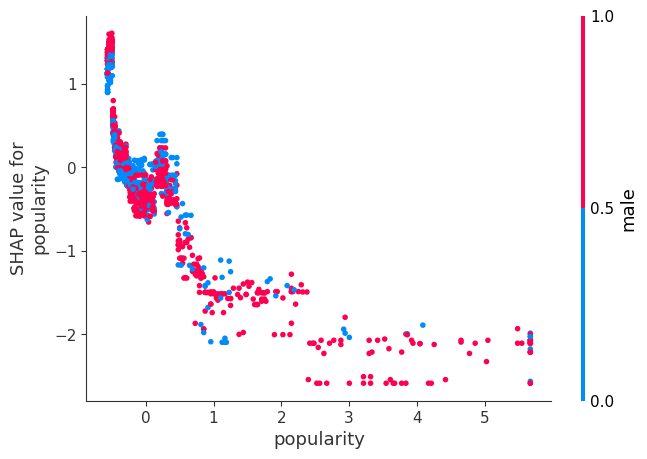

In [204]:
shap.dependence_plot("popularity", shap_values_array, test,interaction_index="male")


In [205]:
explainer.expected_value


0.9819597964544564

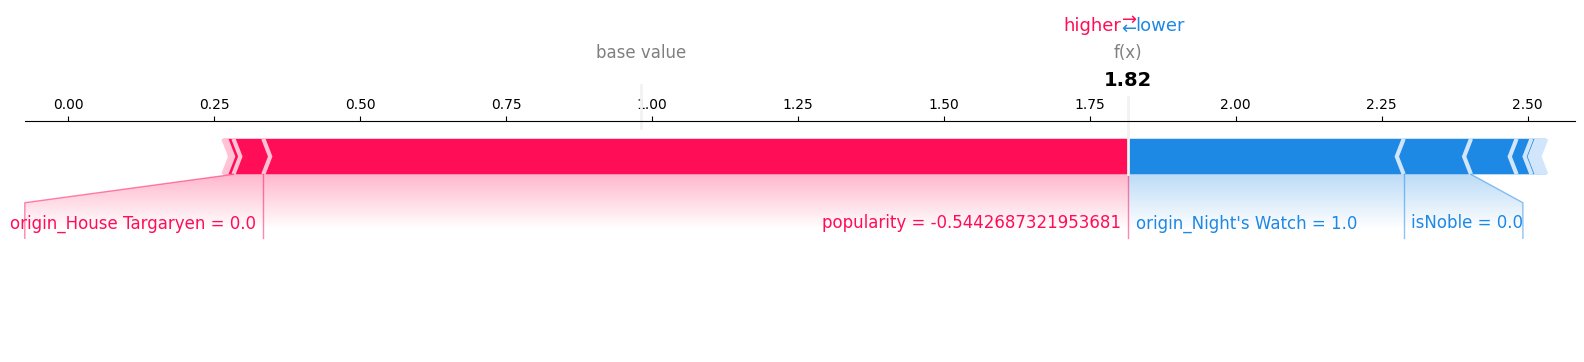

In [206]:
shap.plots.force(explainer.expected_value, shap_values_array[12,:], test.iloc[12, :], matplotlib = True)


In [208]:
y.iloc[25, :]


isAlive    0
Name: 25, dtype: int64

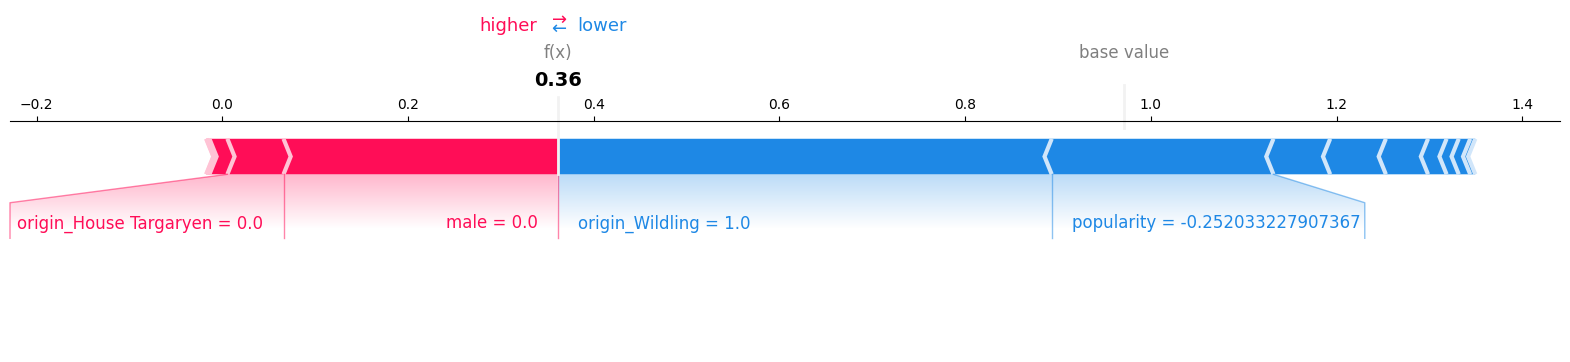

In [176]:
shap.plots.force(explainer.expected_value, shap_values_array[25,:], test.iloc[25, :], matplotlib = True)


In [175]:
y.iloc[25, :]


isAlive    0
Name: 25, dtype: int64

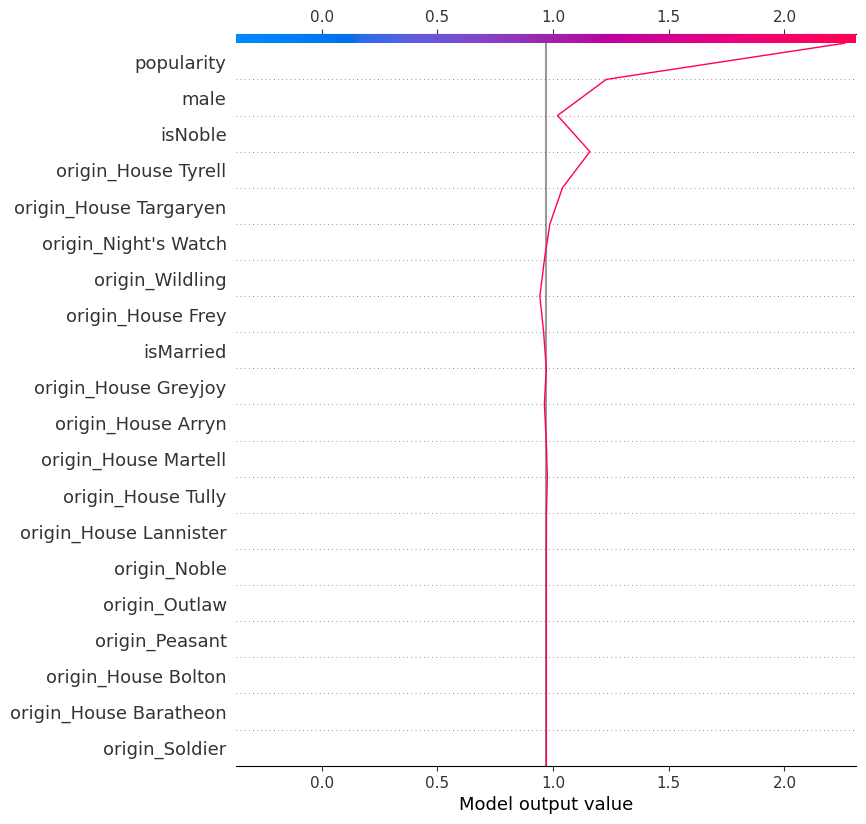

In [180]:
shap.decision_plot(explainer.expected_value, shap_values_array[13,:], test.columns)


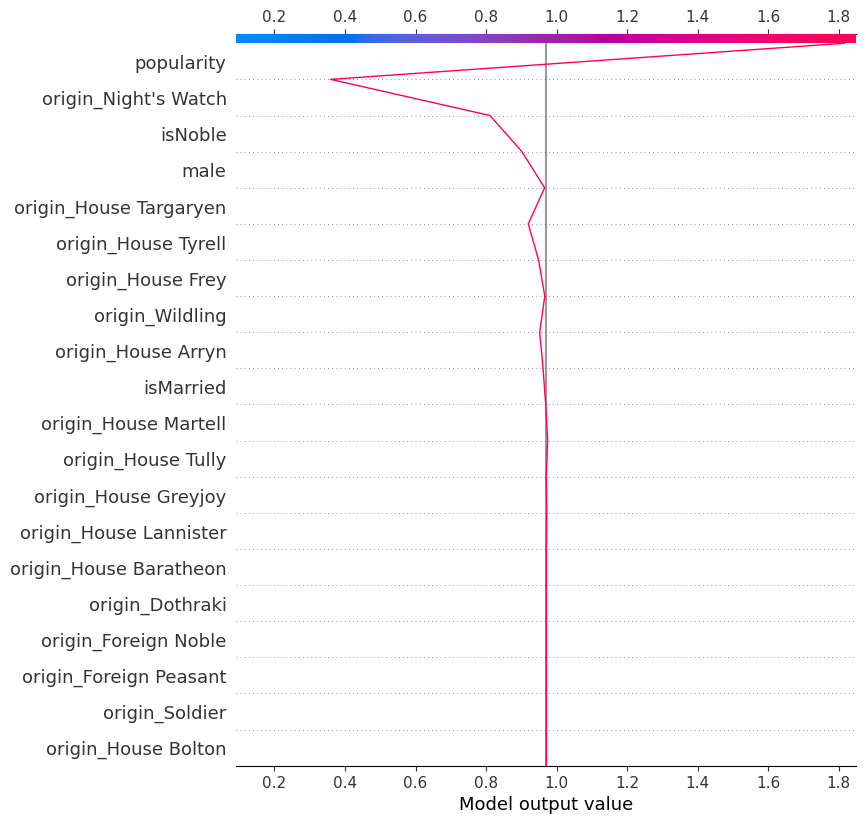

In [181]:
shap.decision_plot(explainer.expected_value, shap_values_array[12,:], test.columns)


In [70]:
[x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]


['popularity',
 'origin_Dothraki',
 'origin_Foreign Noble',
 'origin_Foreign Peasant',
 'origin_House Arryn',
 'origin_House Baratheon',
 'origin_House Bolton',
 'origin_House Frey',
 'origin_House Greyjoy',
 'origin_House Lannister',
 'origin_House Martell',
 'origin_House Stark',
 'origin_House Targaryen',
 'origin_House Tully',
 'origin_House Tyrell',
 "origin_Night's Watch",
 'origin_Noble',
 'origin_Outlaw',
 'origin_Peasant',
 'origin_Soldier',
 'origin_Wildling',
 'isMarried',
 'isNoble',
 'male']

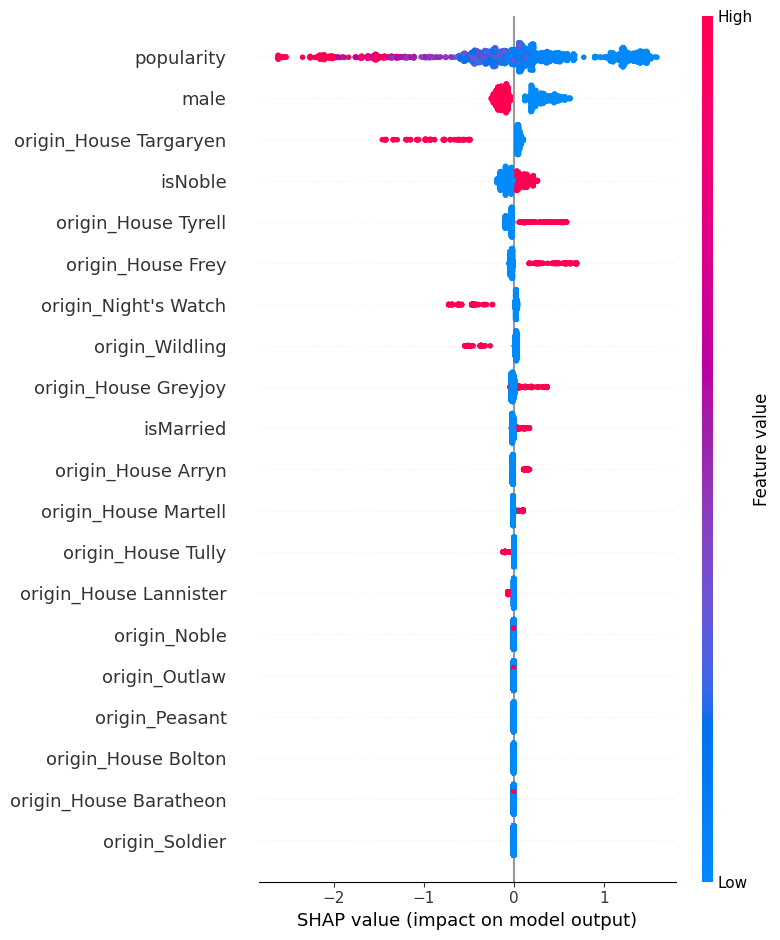

In [71]:
test = pd.DataFrame(X_processed)
test.columns = [x.split("__")[1] for x in model_xgb["columntransformer"].get_feature_names_out()]
shap.summary_plot(shap_values, test)


[1]
popularity                0.582925
origin_Dothraki           0.000000
origin_Foreign Noble      0.000000
origin_Foreign Peasant    0.000000
origin_House Arryn        1.000000
origin_House Baratheon    0.000000
origin_House Bolton       0.000000
origin_House Frey         0.000000
origin_House Greyjoy      0.000000
origin_House Lannister    0.000000
origin_House Martell      0.000000
origin_House Stark        0.000000
origin_House Targaryen    0.000000
origin_House Tully        0.000000
origin_House Tyrell       0.000000
origin_Night's Watch      0.000000
origin_Noble              0.000000
origin_Outlaw             0.000000
origin_Peasant            0.000000
origin_Soldier            0.000000
origin_Wildling           0.000000
isMarried                 1.000000
isNoble                   1.000000
male                      0.000000
Name: 3, dtype: float64


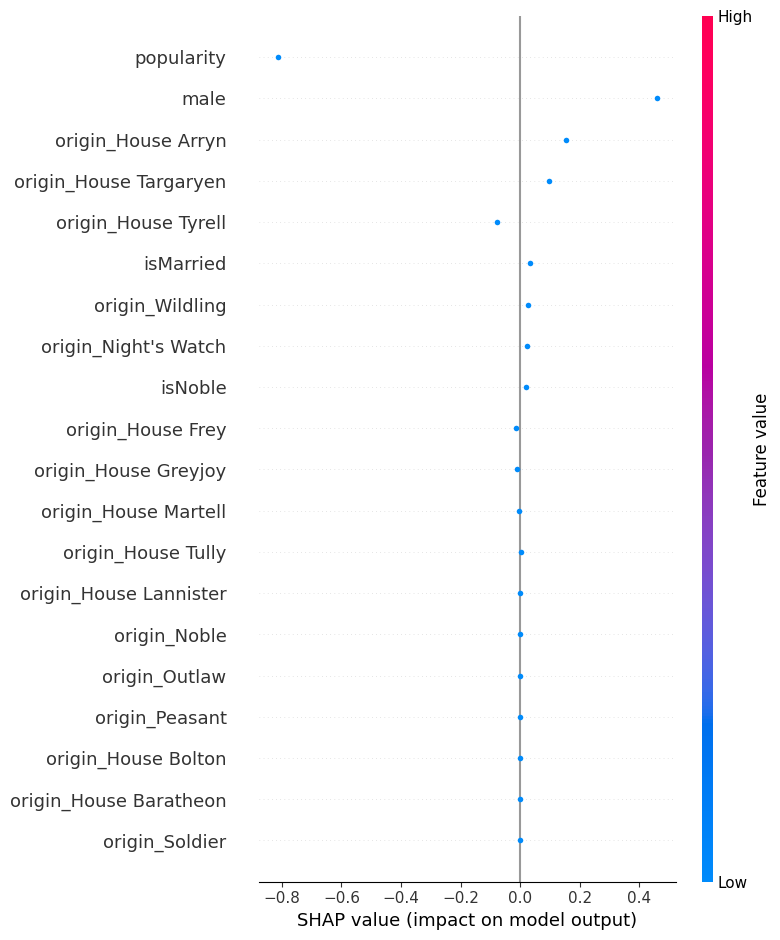

In [124]:
i = 3 #Unpopular Targaryen -> 38
sample = test.iloc[i:i+1]
shap_values = explainer(sample)
print(model_xgb["xgbclassifier"].predict(sample))
print(sample.loc[i])
shap.summary_plot(shap_values, sample)


In [125]:
e1 = exp.generate_counterfactuals(test[i:i+1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Query instance (original outcome : 1)


,popularity,origin_Dothraki,origin_Foreign Noble,origin_Foreign Peasant,origin_House Arryn,origin_House Baratheon,origin_House Bolton,origin_House Frey,origin_House Greyjoy,origin_House Lannister,...,origin_Night's Watch,origin_Noble,origin_Outlaw,origin_Peasant,origin_Soldier,origin_Wildling,isMarried,isNoble,male,isAlive
0,0.582925,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1



Diverse Counterfactual set (new outcome: 0)


,popularity,origin_Dothraki,origin_Foreign Noble,origin_Foreign Peasant,origin_House Arryn,origin_House Baratheon,origin_House Bolton,origin_House Frey,origin_House Greyjoy,origin_House Lannister,...,origin_Night's Watch,origin_Noble,origin_Outlaw,origin_Peasant,origin_Soldier,origin_Wildling,isMarried,isNoble,male,isAlive
0,3.9442237,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0
1,2.9268876,-,-,-,-,-,-,-,-,-,...,-,-,-2.7755575615628914e-17,-,-,-,-,-,-,0.0


  Using cached pandas-1.5.3-cp310-cp310-macosx_10_9_x86_64.whl (12.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 3.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.3
    Uninstalling pandas-2.1.3:
      Successfully uninstalled pandas-2.1.3


In [78]:
test.columns


Index(['popularity', 'origin_Dothraki', 'origin_Foreign Noble',
       'origin_Foreign Peasant', 'origin_House Arryn',
       'origin_House Baratheon', 'origin_House Bolton', 'origin_House Frey',
       'origin_House Greyjoy', 'origin_House Lannister',
       'origin_House Martell', 'origin_House Stark', 'origin_House Targaryen',
       'origin_House Tully', 'origin_House Tyrell', 'origin_Night's Watch',
       'origin_Noble', 'origin_Outlaw', 'origin_Peasant', 'origin_Soldier',
       'origin_Wildling', 'isMarried', 'isNoble', 'male'],
      dtype='object')

In [105]:
merged.dtypes


popularity                float64
origin_Dothraki           float64
origin_Foreign Noble      float64
origin_Foreign Peasant    float64
origin_House Arryn        float64
origin_House Baratheon    float64
origin_House Bolton       float64
origin_House Frey         float64
origin_House Greyjoy      float64
origin_House Lannister    float64
origin_House Martell      float64
origin_House Stark        float64
origin_House Targaryen    float64
origin_House Tully        float64
origin_House Tyrell       float64
origin_Night's Watch      float64
origin_Noble              float64
origin_Outlaw             float64
origin_Peasant            float64
origin_Soldier            float64
origin_Wildling           float64
isMarried                 float64
isNoble                   float64
male                      float64
isAlive                     int64
dtype: object

In [117]:
import dice_ml

# Dataset for training an ML model
d = dice_ml.Data(dataframe=test2,
                 continuous_features=list(merged.columns[:-1]),
                 outcome_name='isAlive')

# Pre-trained ML model
m = dice_ml.Model(model_xgb["xgbclassifier"], backend='sklearn')
# DiCE explanation instance
exp = dice_ml.Dice(d,m)


In [118]:
e1 = exp.generate_counterfactuals(test[i:i+1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

Query instance (original outcome : 1)


,popularity,origin_Dothraki,origin_Foreign Noble,origin_Foreign Peasant,origin_House Arryn,origin_House Baratheon,origin_House Bolton,origin_House Frey,origin_House Greyjoy,origin_House Lannister,...,origin_Night's Watch,origin_Noble,origin_Outlaw,origin_Peasant,origin_Soldier,origin_Wildling,isMarried,isNoble,male,isAlive
0,-0.565143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1



Diverse Counterfactual set (new outcome: 0)


,popularity,origin_Dothraki,origin_Foreign Noble,origin_Foreign Peasant,origin_House Arryn,origin_House Baratheon,origin_House Bolton,origin_House Frey,origin_House Greyjoy,origin_House Lannister,...,origin_Night's Watch,origin_Noble,origin_Outlaw,origin_Peasant,origin_Soldier,origin_Wildling,isMarried,isNoble,male,isAlive
0,1.47389027,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,0.0
1,3.60421029,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,0.6,0.0


In [110]:
i


38